<a href="https://colab.research.google.com/github/AkshayKulla/End-to-End-ML/blob/main/End_to_End_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [55]:
#Importing the required Libraries
# Import Libraries and modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob
from IPython.display import Image
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import gensim

import warnings
warnings.filterwarnings('ignore')


In [46]:
#Attatching the database
# Load the clustering dataset
clustering_dataset_path = '/content/drive/MyDrive/DATASETS/Zomato Restaurant names and Metadata.csv'
clustering_df = pd.read_csv(clustering_dataset_path)

# Load the sentiment analysis dataset
sentiment_dataset_path = '/content/drive/MyDrive/DATASETS/Zomato Restaurant reviews.csv'
sentiment_df = pd.read_csv(sentiment_dataset_path)

## ***1. Know Your Data***

In [47]:
# Display the first few rows of the DataFrame
display(clustering_df.head())
display(sentiment_df.head())

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [48]:
# Calculate summary statistics for numerical features
summary_stats = clustering_df.describe()
print("Summary Statistics:")
display(summary_stats)
summary_stats = sentiment_df.describe()
print("Summary Statistics:")
display(summary_stats)

Summary Statistics:


,Name,Links,Cost,Collections,Cuisines,Timings
count,105,105,105,51,105,104
unique,105,105,29,42,92,77
top,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,500,Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,4,6


Summary Statistics:


,Pictures
count,10000.000000
mean,0.748600
std,2.570381
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,64.000000


In [49]:
# Check the data types of each feature
data_types1 = clustering_df.dtypes
print("\nData Types:")
display(data_types1)

data_types2 = sentiment_df.dtypes
print("\nData Types:")
display(data_types2)



Data Types:


Name           object
Links          object
Cost           object
Collections    object
Cuisines       object
Timings        object
dtype: object


Data Types:


Restaurant    object
Reviewer      object
Review        object
Rating        object
Metadata      object
Time          object
Pictures       int64
dtype: object

In [50]:
# Identify and handle any missing values in the dataset
missing_values1 = clustering_df.isnull().sum()
print("\nMissing Values:")
display(missing_values1)
missing_values2 = sentiment_df.isnull().sum()
print("\nMissing Values:")
display(missing_values2)


Missing Values:


Name            0
Links           0
Cost            0
Collections    54
Cuisines        0
Timings         1
dtype: int64


Missing Values:


Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

Handling the missing Values

In [54]:
# Handle missing values in the 'Collections' column by imputing with mode
collections_mode = clustering_df['Collections'].mode()[0]
clustering_df['Collections'].fillna(collections_mode, inplace=True)

# Handle missing values in the 'Timings' column by imputing with 'Not available'
clustering_df['Timings'].fillna('Not available', inplace=True)

# Verify that missing values have been handled
missing_values_after_handling = clustering_df.isnull().sum()
print("\nMissing Values After Handling:")
display(missing_values_after_handling)

import pandas as pd
from sklearn.impute import SimpleImputer

# Convert 'Rating' column to numeric and round to nearest integer
sentiment_df['Rating'] = pd.to_numeric(sentiment_df['Rating'], errors='coerce').round().astype('Int64')

# Display missing values counts
print("Missing Values:")
print(sentiment_df.isnull().sum())

# Remove rows with missing values in specific columns
sentiment_df.dropna(subset=['Reviewer', 'Review', 'Rating', 'Metadata', 'Time'], inplace=True)

# Handle missing values for numeric columns (if any)
numeric_columns = ['Rating']  # Add other numeric columns here if needed
imputer_numeric = SimpleImputer(strategy='mean')
sentiment_df[numeric_columns] = imputer_numeric.fit_transform(sentiment_df[numeric_columns])

# Convert 'Rating' column to integer type
sentiment_df['Rating'] = sentiment_df['Rating'].astype(int)

# Confirm missing values are handled
print("\nMissing Values after Handling:")
print(sentiment_df.isnull().sum())




Missing Values After Handling:


Name           0
Links          0
Cost           0
Collections    0
Cuisines       0
Timings        0
dtype: int64

Missing Values:
Restaurant    0
Reviewer      0
Review        0
Rating        1
Metadata      0
Time          0
Pictures      0
dtype: int64

Missing Values after Handling:
Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64


In [16]:
# List of categorical variables
categorical_variables = ['Name', 'Links', 'Collections', 'Cuisines', 'Timings']

# Check unique values and frequencies for categorical variables
for feature in categorical_variables:
    unique_values = clustering_df[feature].value_counts()
    print(f"\nUnique Values for {feature}:")
    display(unique_values)



Unique Values for Name:


Beyond Flavours                           1
Diners Pavilion                           1
Squeeze @ The Lime                        1
The Old Madras Baking Company             1
Royal Spicy Restaurant                    1
                                         ..
Marsala Food Company                      1
Pista House                               1
Pot Pourri                                1
Hunger Maggi Point                        1
Republic Of Noodles - Lemon Tree Hotel    1
Name: Name, Length: 105, dtype: int64


Unique Values for Links:


https://www.zomato.com/hyderabad/beyond-flavours-gachibowli                         1
https://www.zomato.com/hyderabad/diners-pavilion-gachibowli                         1
https://www.zomato.com/hyderabad/squeeze-the-lime-gachibowli                        1
https://www.zomato.com/hyderabad/the-old-madras-baking-company-gachibowli           1
https://www.zomato.com/hyderabad/royal-spicy-restaurant-gachibowli                  1
                                                                                   ..
https://www.zomato.com/hyderabad/marsala-food-company-gachibowli                    1
https://www.zomato.com/hyderabad/pista-house-2-gachibowli                           1
https://www.zomato.com/hyderabad/pot-pourri-gachibowli                              1
https://www.zomato.com/hyderabad/hunger-maggi-point-gachibowli                      1
https://www.zomato.com/hyderabad/republic-of-noodles-lemon-tree-hotel-gachibowli    1
Name: Links, Length: 105, dtype: int64


Unique Values for Collections:


Food Hygiene Rated Restaurants in Hyderabad                                                                                                       58
Great Buffets                                                                                                                                      2
Hyderabad's Hottest                                                                                                                                2
New on Gold                                                                                                                                        2
Pan-Asian Delicacies                                                                                                                               2
Veggie Friendly                                                                                                                                    2
Trending This Week                                                                                        


Unique Values for Cuisines:


North Indian, Chinese                                   4
North Indian                                            3
Ice Cream, Desserts                                     2
Biryani, North Indian, Chinese                          2
South Indian, North Indian, Chinese                     2
                                                       ..
Biryani, South Indian, North Indian, Chinese, Andhra    1
Italian, North Indian, South Indian, Asian              1
North Indian, Fast Food                                 1
Arabian, North Indian, Chinese                          1
Thai, Asian, Chinese, Malaysian                         1
Name: Cuisines, Length: 92, dtype: int64


Unique Values for Timings:


11 AM to 11 PM                                                                                                                                                              6
12 Noon to 11 PM                                                                                                                                                            5
12 Noon to 12 Midnight                                                                                                                                                      5
11:30 AM to 1 AM                                                                                                                                                            3
12 Noon to 10:30 PM                                                                                                                                                         3
                                                                                                                                  

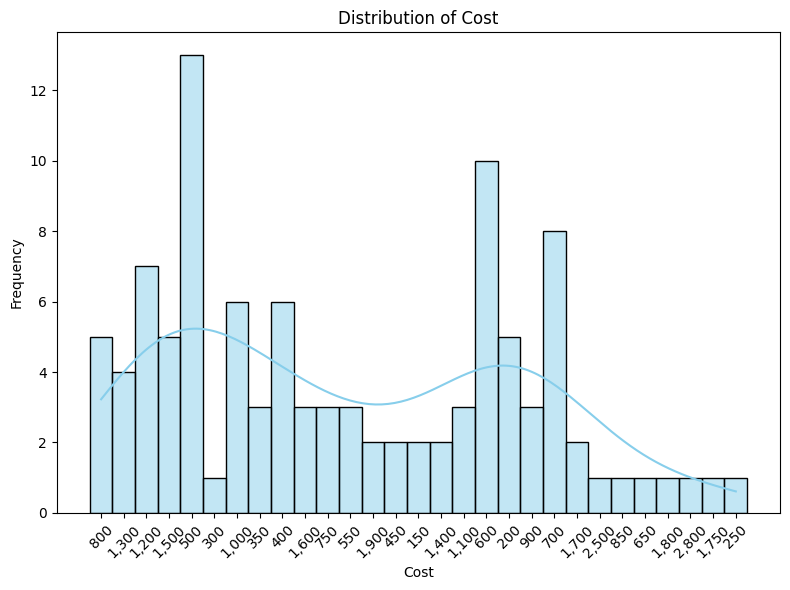

In [18]:
# Visualize the distribution of the 'Cost' feature using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(clustering_df['Cost'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


<ipython-input-21-90b316258173>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=clustering_df, y='Cuisines', order=cuisine_counts.index[:10], palette='Set3')


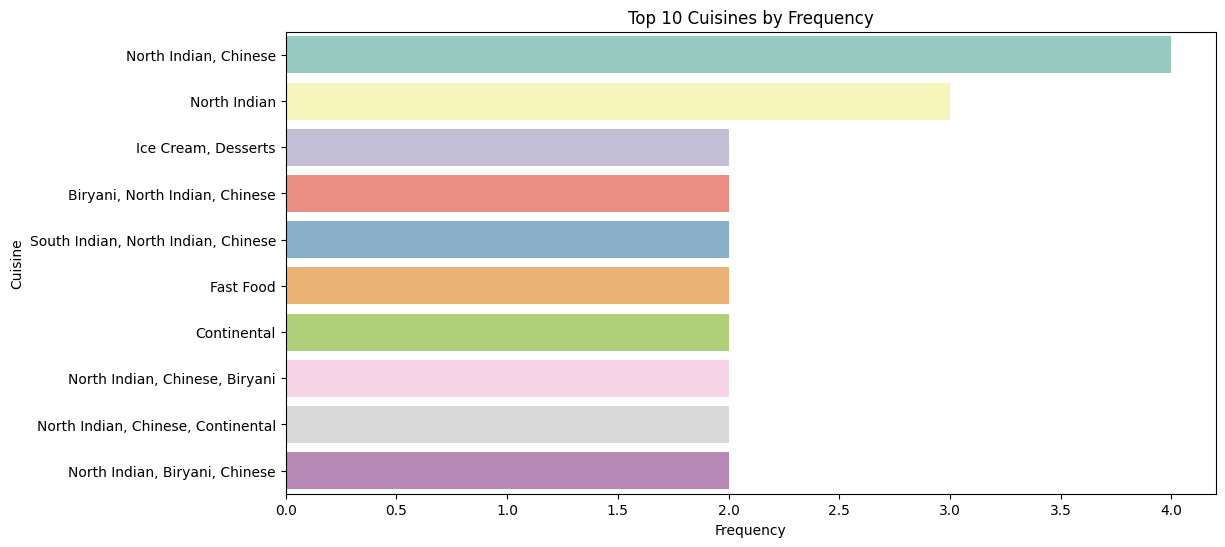

In [21]:
# Aggregate the data by counting the occurrences of each cuisine
cuisine_counts = clustering_df['Cuisines'].value_counts()

# Visualize the distribution of cuisines using a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=clustering_df, y='Cuisines', order=cuisine_counts.index[:10], palette='Set3')
plt.title('Top 10 Cuisines by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.show()


## 2. ***Variables Description***

Zomato Restaurant names and Metadata
Name : Name of Restaurants

Links : URL Links of Restaurants

Cost : Per person estimated Cost of dining

Collection : Tagging of Restaurants w.r.t. Zomato categories

Cuisines : Cuisines served by Restaurants

Timings : Restaurant Timings

Zomato Restaurant reviews
Restaurant : Name of the Restaurant

Reviewer : Name of the Reviewer

Review : Review Text

Rating : Rating Provided by Reviewer

MetaData : Reviewer Metadata - No. of Reviews and followers

Time: Date and Time of Review

Pictures : No. of pictures posted with review

## 3. ***Data Wrangling***

In [57]:
# Convert the 'Cost' column, deleting the comma and changing the data type into 'int64'.

clustering_df['Cost'] =  clustering_df['Cost'].str.replace(",","").astype('int64')

In [58]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    int64 
 3   Collections  105 non-null    object
 4   Cuisines     105 non-null    object
 5   Timings      105 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.0+ KB


## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

In [60]:
# Chart - 1 visualization code.

top10_res_by_cost = clustering_df[['Name','Cost']].groupby('Name',as_index=False).sum().sort_values(by='Cost',ascending=False).head(10)

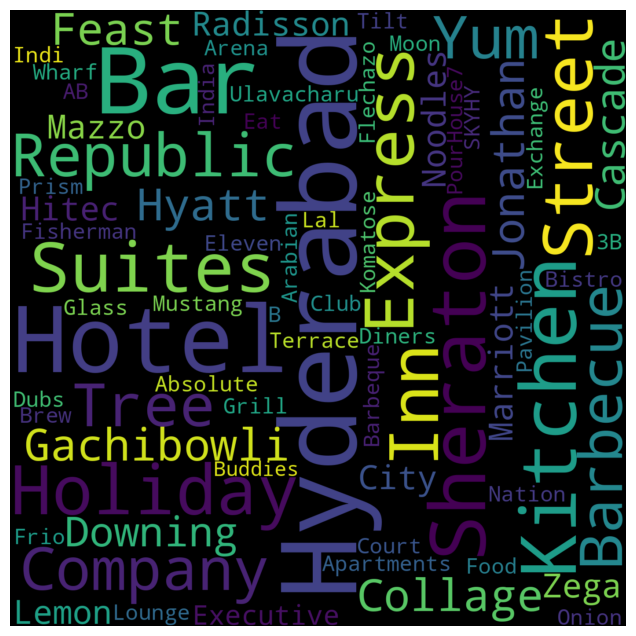

In [66]:
# Creating word cloud for Top expensive restaurants.
plt.figure(figsize=(15,8))
text = " ".join(name for name in clustering_df.sort_values('Cost',ascending=False).Name[:30])

# Creating word_cloud with text as argument in .generate() method.
word_cloud = WordCloud(width = 1400, height = 1400,collocations = False, background_color = 'black').generate(text)

# Display the generated Word Cloud.
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off");